# Importing the necessary libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set()

In [2]:
choc = pd.read_csv('traintest.csv')

# One-hot encoding for categorical variables

In [3]:
# one hot encoding
choc_ohe = choc[['country_of_bean_origin',
                 'first_taste', 'second_taste', 'third_taste', 'fourth_taste']]
choc_ohe = pd.get_dummies(data = choc_ohe)

# extracting rest of the predictors
choc_num = choc[['cocoa_percent', 'counts_of_ingredients', 'number_of_taste',
                 'vanilla', 'lecithin', 'salt', 'sugar']]

# extracting response
choc_response = choc['rating_category']

# combining predictors and response
choc_ohe = pd.concat([choc_ohe, choc_response, choc_num], sort = False, axis = 1)

For our models, we are going to use Stratified K Fold cross validation to evaluate the model, as well as calculating its accuracy rate on a training and testing data set

In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, train_test_split

In [5]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

Extract response and predictor variables, and split train and test set

In [6]:
y = pd.DataFrame(choc_ohe['rating_category'])
X = pd.DataFrame(choc_ohe.drop('rating_category', axis = 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# Creating helper function for decision tree and random forest

In [7]:
def evalModel(classifier, X, y, scoring):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    n_scores = cross_validate(classifier, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')
    print('accuracy: %.3f (%.3f)' % (np.mean(n_scores["test_accuracy"]), np.std(n_scores["test_accuracy"])))
    print('precison: %.3f (%.3f)' % (np.mean(n_scores["test_precision"]), np.std(n_scores["test_precision"])))
    print('recall: %.3f (%.3f)' % (np.mean(n_scores["test_recall"]), np.std(n_scores["test_recall"])))
    print('f1 score: %.3f (%.3f)' % (np.mean(n_scores["test_f1_score"]), np.std(n_scores["test_f1_score"])))

def fitModel(classifier, X_train, X_test, y_train, y_test):
    # train thetree model
    classifier.fit(X_train, y_train.rating_category.ravel())

    # Predict Response corresponding to Predictors
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)

    # Check the Goodness of Fit on Train Data
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", classifier.score(X_train, y_train))
    print()
    # Check the Goodness of Fit on Test Data
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", classifier.score(X_test, y_test))
    print()

    trainData = confusion_matrix(y_train, y_train_pred)
    testData = confusion_matrix(y_test, y_test_pred)

    print("True '1' rate Train :\t", (trainData[1][1]/(trainData[1][0]+trainData[1][1])))
    print("True '0' rate Train :\t", (trainData[0][0]/(trainData[0][0]+trainData[0][1])))
    print()
    print("False '1' rate Train :\t", ((trainData[0][1])/((trainData[0][1]+trainData[0][0]))))
    print("False '0' rate Train :\t", ((trainData[1][0])/((trainData[1][0]+trainData[1][1]))))
    print()
    print("True '1' rate Test :\t", (testData[1][1]/(testData[1][0]+testData[1][1])))
    print("True '0' rate Test :\t", (testData[0][0]/(testData[0][0]+testData[0][1])))
    print()
    print("False '1' rate Test :\t", ((testData[0][1])/((testData[0][1]+testData[0][0]))))
    print("False '0' rate Test :\t", ((testData[1][0])/((testData[1][0]+testData[1][1]))))
    print()

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(2, 1, figsize=(8, 16))
    sb.heatmap(trainData, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(testData,  annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Classification tree

We start off with a very simple model, a decision tree classifier

In [8]:
from sklearn.tree import DecisionTreeClassifier

Using stratified K fold cross validation to evaluate the model

In [9]:
dectree = DecisionTreeClassifier(max_depth = 40)
evalModel(dectree, X, y, scoring)

accuracy: 0.626 (0.021)
precison: 0.655 (0.017)
recall: 0.747 (0.050)
f1 score: 0.697 (0.023)


Test the model on a train and test data set

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9119106699751861

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6377171215880894

True '1' rate Train :	 0.9935553168635876
True '0' rate Train :	 0.8002936857562408

False '1' rate Train :	 0.19970631424375918
False '0' rate Train :	 0.00644468313641246

True '1' rate Test :	 0.7896995708154506
True '0' rate Test :	 0.4294117647058823

False '1' rate Test :	 0.5705882352941176
False '0' rate Test :	 0.21030042918454936



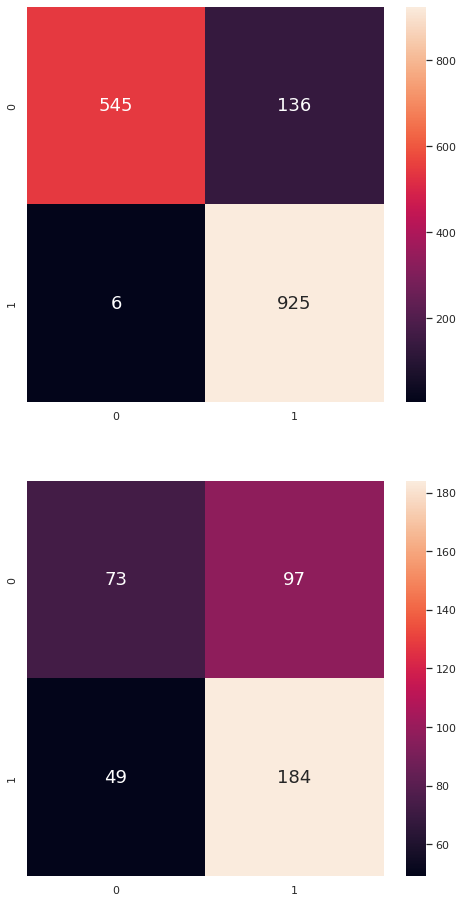

In [10]:
fitModel(dectree, X_train, X_test, y_train, y_test)

Overall, the Classification Tree model did quite a bad job of predicting our chocolate rating, let's see how we can improve upon that accuracy.

# Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

Using stratified K fold cross validation to evaluate the model

In [12]:
rforest = RandomForestClassifier(n_estimators = 800, max_depth = 80)
evalModel(rforest, X, y, scoring)

accuracy: 0.680 (0.015)
precison: 0.676 (0.014)
recall: 0.857 (0.022)
f1 score: 0.756 (0.011)


Test the model on a train and test data set

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9950372208436724

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6997518610421837

True '1' rate Train :	 1.0
True '0' rate Train :	 0.9882525697503671

False '1' rate Train :	 0.011747430249632892
False '0' rate Train :	 0.0

True '1' rate Test :	 0.8412017167381974
True '0' rate Test :	 0.5058823529411764

False '1' rate Test :	 0.49411764705882355
False '0' rate Test :	 0.15879828326180256



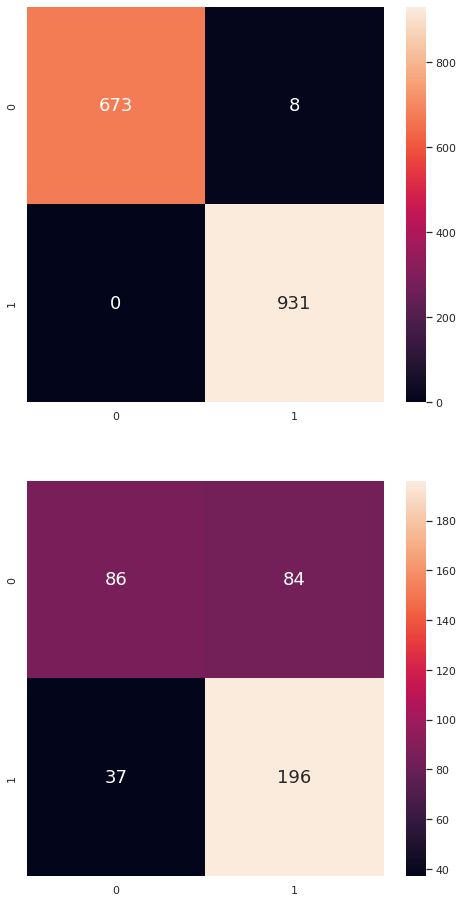

In [13]:
fitModel(rforest, X_train, X_test, y_train, y_test)

We have good accuracy on the training data set, but horrible accuracy on the test dataset, this might be a case of overfitting.
We predict too much '0' value as '1', which can mess with our prediction of a highly rated chocolate bar

# Upsampling the minority class in rating category

In [14]:
# See which category of rating is imbalanced
choc_ohe.rating_category.value_counts()

1    1164
0     851
Name: rating_category, dtype: int64

In [15]:
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [16]:
rforest = RandomForestClassifier(n_estimators = 600, max_depth = 60)
over = ADASYN()
under = RandomUnderSampler(sampling_strategy=0.5) 
steps = [("smote", over),("model", rforest)]
pipeline = Pipeline(steps = steps)

Experimented with different kind of SMOTE algorithms, including SMOTE, SVMSMOTE, BorderlineSMOTE, KMeansSMOTE and ADASYN.
Found that ADASYN generally resulted in the best parameters

Using stratified K fold cross validation to evalute the model

In [17]:
evalModel(pipeline, X, y, scoring)

accuracy: 0.641 (0.023)
precison: 0.755 (0.022)
recall: 0.561 (0.037)
f1 score: 0.643 (0.028)


Test the model on a train and test data set

In [18]:
y_train.value_counts()

rating_category
1                  931
0                  681
dtype: int64

In [19]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
y_train_res.value_counts()

rating_category
1                  931
0                  869
dtype: int64

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9955555555555555

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6575682382133995

True '1' rate Train :	 1.0
True '0' rate Train :	 0.9907940161104718

False '1' rate Train :	 0.009205983889528193
False '0' rate Train :	 0.0

True '1' rate Test :	 0.5665236051502146
True '0' rate Test :	 0.7823529411764706

False '1' rate Test :	 0.21764705882352942
False '0' rate Test :	 0.4334763948497854



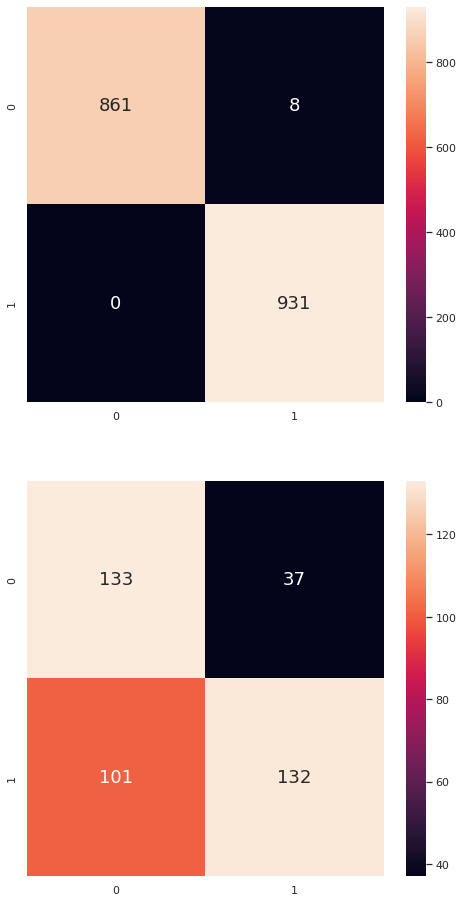

In [20]:
fitModel(rforest, X_train_res, X_test, y_train_res, y_test)

Better accuracy, and better recall rate as well

# Removing minority classes in predictors

In [21]:
beanOriginCounts = pd.DataFrame(choc['country_of_bean_origin'].value_counts())
beanOriginTop = beanOriginCounts[beanOriginCounts['country_of_bean_origin'] > 40].reset_index()
beanOriginTop

,index,country_of_bean_origin
0,Venezuela,220
1,Peru,188
2,Dominican republic,182
3,Ecuador,159
4,Madagascar,151
5,Blend,101
6,Nicaragua,87
7,Bolivia,67
8,Brazil,65
9,Tanzania,62


In the column `country_of_bean_origin`, there are a lot of data which only appeared very few times.

In [22]:
choc_xoutlier = choc[choc["country_of_bean_origin"].isin(beanOriginTop["index"])].reset_index(drop=True)
choc_xoutlier

,country_of_bean_origin,cocoa_percent,rating_category,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,salt,sugar,first_taste,second_taste,third_taste,fourth_taste,number_of_taste
0,Madagascar,76.0,1,3.75,3,1,0,0,0,1,cocoa,blackberry,full body,no taste,3
1,Dominican republic,76.0,1,3.50,3,1,0,0,0,1,cocoa,vegetal,savory,no taste,3
2,Tanzania,76.0,1,3.25,3,1,0,0,0,1,rich cocoa,fatty,bready,no taste,3
3,Bolivia,70.0,1,3.50,4,1,0,1,0,1,vegetal,nutty,no taste,no taste,2
4,Venezuela,70.0,1,4.00,4,1,0,1,0,1,oily,nut,caramel,raspberry,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,Papua new guinea,75.0,0,3.00,4,1,0,0,1,0,hint of smoke,fruit,no taste,no taste,2
1599,Blend,80.0,0,2.75,4,1,0,0,1,0,waxy,cloying,vegetal,no taste,3
1600,Colombia,75.0,1,3.75,3,1,0,0,0,1,strong nutty,marshmallow,no taste,no taste,2
1601,Belize,72.0,1,3.50,3,1,0,0,0,1,muted,roasty,accessible,no taste,3


In [23]:
# one hot encoding
choc_xoutlier_ohe = choc_xoutlier[['country_of_bean_origin',
                 'first_taste', 'second_taste', 'third_taste', 'fourth_taste']]
choc_xoutlier_ohe = pd.get_dummies(data = choc_xoutlier_ohe)

# extracting rest of the predictors
choc_num = choc_xoutlier[['cocoa_percent', 'counts_of_ingredients', 'number_of_taste',
                          'vanilla', 'lecithin', 'salt', 'sugar']]

# extracting response
choc_response = choc_xoutlier['rating_category']

# combining predictors and response
choc_xoutlier_ohe = pd.concat([choc_xoutlier_ohe, choc_response, choc_num], sort = False, axis = 1)

In [24]:
choc_xoutlier_ohe.rating_category.value_counts()

1    945
0    658
Name: rating_category, dtype: int64

In [25]:
y = pd.DataFrame(choc_xoutlier_ohe['rating_category'])
X = pd.DataFrame(choc_xoutlier_ohe.drop('rating_category', axis = 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [26]:
rforest = RandomForestClassifier(n_estimators = 400, max_depth = 60)
over = ADASYN()
under = RandomUnderSampler(sampling_strategy=0.5) 
steps = [("smote", over),("model", rforest)]
pipeline = Pipeline(steps = steps)

Using stratified K fold cross validation to evalute the model

In [27]:
evalModel(rforest, X, y, scoring)

accuracy: 0.679 (0.015)
precison: 0.676 (0.012)
recall: 0.877 (0.026)
f1 score: 0.763 (0.012)


Test the model on a train and test data set

In [28]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
y_train_res.value_counts()

rating_category
1                  756
0                  679
dtype: int64

Test the model on a train and test data set

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9965156794425087

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6448598130841121

True '1' rate Train :	 0.9986772486772487
True '0' rate Train :	 0.9941089837997055

False '1' rate Train :	 0.005891016200294551
False '0' rate Train :	 0.0013227513227513227

True '1' rate Test :	 0.5767195767195767
True '0' rate Test :	 0.7424242424242424

False '1' rate Test :	 0.25757575757575757
False '0' rate Test :	 0.42328042328042326



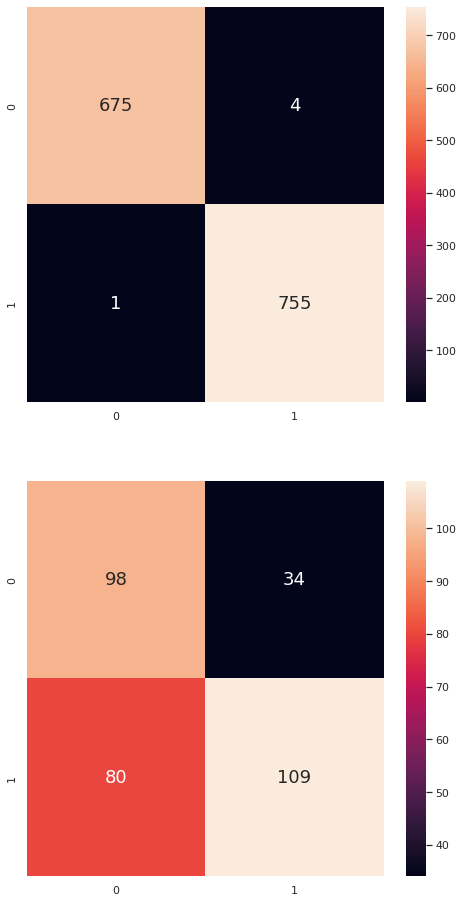

In [29]:
fitModel(rforest, X_train_res, X_test, y_train_res, y_test)

To add comment here

# Gradient Boosting

Let's try a more sophisticated model, Gradient Boosting Machine

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
# gradient boosting for classification in scikit-learn

In [31]:
GradBoost = GradientBoostingClassifier(loss = "deviance", learning_rate = 0.1, n_estimators = 500, subsample = 0.5, max_depth = 6)
over = ADASYN()
under = RandomUnderSampler(sampling_strategy=0.5) 
steps = [("smote", over),("model", GradBoost)]
pipeline = Pipeline(steps = steps)

Using stratified K fold cross validation to evalute the model

In [32]:
evalModel(pipeline, X, y, scoring)

accuracy: 0.675 (0.028)
precison: 0.723 (0.023)
recall: 0.729 (0.042)
f1 score: 0.726 (0.026)


Test the model on a train and test data set

In [33]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
y_train_res.value_counts()

rating_category
1                  756
0                  679
dtype: int64

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9951219512195122

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.67601246105919

True '1' rate Train :	 1.0
True '0' rate Train :	 0.9896907216494846

False '1' rate Train :	 0.010309278350515464
False '0' rate Train :	 0.0

True '1' rate Test :	 0.7195767195767195
True '0' rate Test :	 0.6136363636363636

False '1' rate Test :	 0.38636363636363635
False '0' rate Test :	 0.2804232804232804



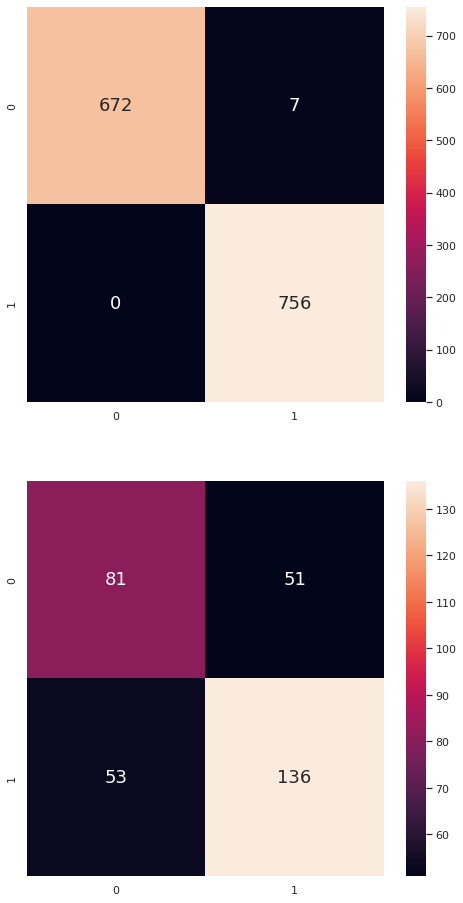

In [34]:
fitModel(GradBoost, X_train_res, X_test, y_train_res, y_test)

## Without removing outliers

In [35]:
y = pd.DataFrame(choc_ohe['rating_category'])
X = pd.DataFrame(choc_ohe.drop('rating_category', axis = 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [36]:
y_train.rating_category.value_counts()

1    931
0    681
Name: rating_category, dtype: int64

In [37]:
GradBoost = GradientBoostingClassifier(loss = "deviance", learning_rate = 0.08, n_estimators = 700, subsample = 0.8, max_depth = 9)
over = ADASYN()
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [("smote", over),("model", GradBoost)]
pipeline = Pipeline(steps = steps)

In [38]:
evalModel(pipeline, X, y, scoring)

accuracy: 0.670 (0.024)
precison: 0.719 (0.021)
recall: 0.706 (0.038)
f1 score: 0.712 (0.024)


In [39]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
y_train_res.value_counts()

rating_category
1                  931
0                  880
dtype: int64

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9983434566537824

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6575682382133995

True '1' rate Train :	 1.0
True '0' rate Train :	 0.9965909090909091

False '1' rate Train :	 0.003409090909090909
False '0' rate Train :	 0.0

True '1' rate Test :	 0.6866952789699571
True '0' rate Test :	 0.6176470588235294

False '1' rate Test :	 0.38235294117647056
False '0' rate Test :	 0.3133047210300429



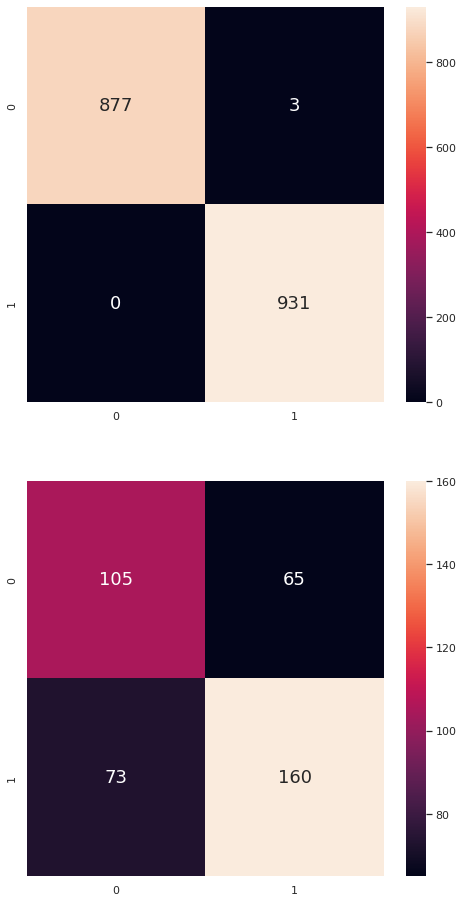

In [40]:
fitModel(GradBoost, X_train_res, X_test, y_train_res, y_test)